# TODO:
1. Sampling from large data set for prototype
2. Writeup

In [1]:
# Importing Libraries
import os
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

# Loading custom built functions
from model.nearest_neighbor_model import KNN
from model.lightfm_model import lightfm_model
from model.baseline_model import baseline_bias_model
from model.als_model import get_best_rank, cross_validation, plot_performance_als
from utils.data_loader import load_spark_df, load_pandas_df, spark_to_sparse, sample_data_frame

from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder
from surprise.prediction_algorithms.knns import KNNWithZScore

## 1. Loading Data 

We implement a function to cache and load the dataframe from secondary memory to reduce data load time

In [2]:
# Setting Directory path
base_path = os.getcwd()
dir_name = 'ml-latest-small'
CACHE_DIR = base_path + '/cache/'
DATA_DIR =  base_path + '/data/'

# Loading the Data Frames
movies_spark_df = load_spark_df(dir_name=dir_name, 
                                file_name='movies', 
                                use_cache=True,
                                DATA_DIR=DATA_DIR,
                                CACHE_DIR=CACHE_DIR
                               )

ratings_spark_df = load_spark_df(dir_name=dir_name, 
                                 file_name='ratings', 
                                 use_cache=True,
                                 DATA_DIR=DATA_DIR,
                                 CACHE_DIR=CACHE_DIR)
print('\nSampling DataFrame ...')
ratings_spark_df = sample_data_frame(ratings_spark_df, ratio=0.1, min_user_threshold=5, min_item_threshold=5)

Loading from /media/anirudh/Data/Code/Fall 2019/Personalization/project/personalization_1/cache/ml-latest-small_movies.msgpack
Loading from /media/anirudh/Data/Code/Fall 2019/Personalization/project/personalization_1/cache/ml-latest-small_ratings.msgpack
Length before sampling: 100836
Length after sampling: 10094
Length after thresholding: 10008


## 2. Analysis of methods

### 2.1 Baseline Method: Bias based model

We first fit a bias only model to the data to set a benchmark for baseline model. 

In [3]:
%%time

baseline_bias_model(ratings_spark_df)

Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9450  0.9440  0.9262  0.9543  0.9683  0.9476  0.0138  
MAE (testset)     0.7397  0.7439  0.7342  0.7412  0.7517  0.7421  0.0057  
Fit time          0.02    0.01    0.01    0.01    0.01    0.01    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


CPU times: user 1.03 s, sys: 58.4 ms, total: 1.09 s
Wall time: 1.95 s


### 2.2 Model based method using Alternating Least Squares method

We build a Matrix Factorization model using ALS method, and iterate over diffrent rank ranges to find the optimal rank

#### 2.2.1 Finding best hyperparameter setting using cross validation

In [4]:
%%time

# Creating a Parameter Grid for ALS
model = ALS(userCol="userId",
                  itemCol="movieId",
                  ratingCol="rating",
                  coldStartStrategy="drop",
                  nonnegative=True)

paramGrid = ParamGridBuilder() \
            .addGrid(model.maxIter, [3]) \
            .addGrid(model.regParam, [0.01,0.1]) \
            .addGrid(model.rank, [64, 128]) \
            .build()

# Finding best parameter combination from cross validation
best_hyper_parameter, best_model = cross_validation(ratings_spark_df, 
                                                     model=model, 
                                                     evaluator='Regression', 
                                                     param_grid=paramGrid, 
                                                     k_folds=3)

print("Best Hyper-parameter combination for ALS Model:")
display(best_hyper_parameter)
print('\n')

RMSE of Best Model on Test Set: 1.2784
Best Hyper-parameter combination for ALS Model:


,HyperParameter,Value
0,maxIter,3
1,regParam,0.01
2,rank,128




CPU times: user 809 ms, sys: 212 ms, total: 1.02 s
Wall time: 36.5 s


#### 2.1.2 For diffrent ranks, plotting RMSE and coverage on training and test set

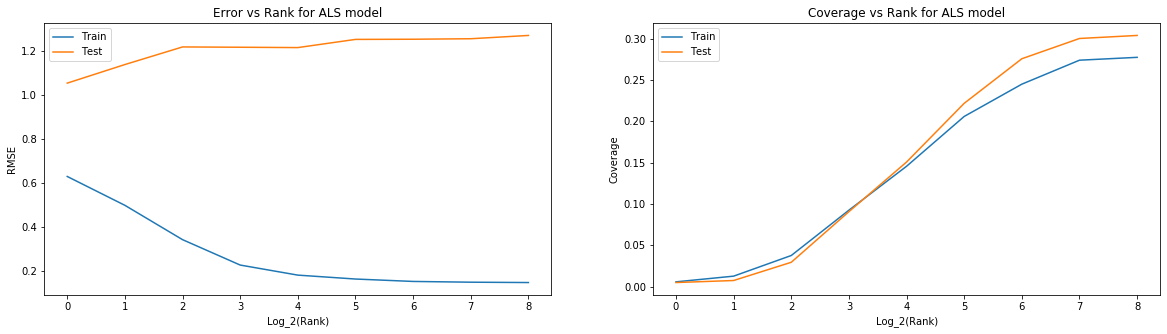

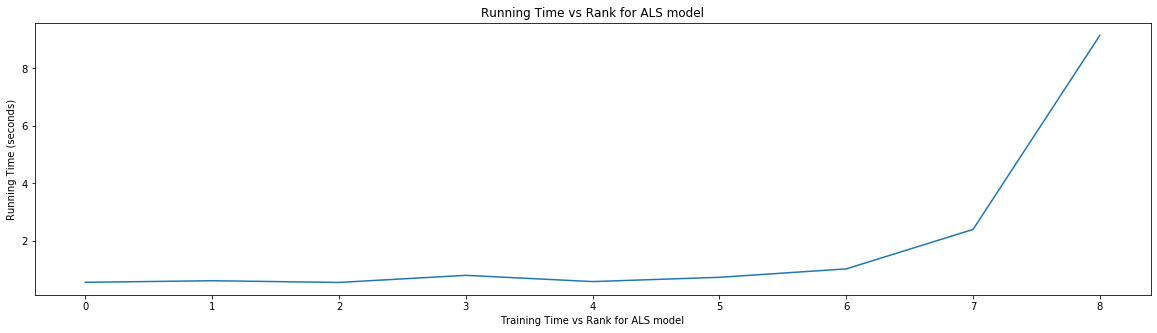

,Rank,RMSE_train,RMSE_test,Coverage_train,Coverage_test,Running_time
0,1.0,0.629316,1.054384,0.005744,0.004902,0.557951
1,2.0,0.497916,1.139009,0.012636,0.007353,0.613364
2,4.0,0.341592,1.219198,0.037622,0.029412,0.553478
3,8.0,0.225936,1.217792,0.092476,0.090686,0.800722
4,16.0,0.180092,1.216238,0.145606,0.150735,0.583211
5,32.0,0.162314,1.253480,0.205916,0.221814,0.732106
6,64.0,0.151330,1.254265,0.244974,0.275735,1.025087
7,128.0,0.147888,1.256530,0.273980,0.300245,2.397090
8,256.0,0.146327,1.271509,0.277427,0.303922,9.149028




CPU times: user 1.83 s, sys: 480 ms, total: 2.31 s
Wall time: 54.3 s


In [5]:
%%time

pow_two_max_rank = 8

ranks = [2**i for i in range(pow_two_max_rank+1)]

report_df = get_best_rank(ratings_spark_df, ranks=ranks)

plot_performance_als(report_df)
display(report_df)
print('\n')

We observe the following:
1. The training error keeps on decreasing with increased rank, but the test error shows no significant improvement indicating signs of overfitting
2. The coverage of items improves with respect to rank
3. The time to fit the model takes expontially higher time in correlation with rank

Note: We use Catalog Coverage to take into account the number of unique movies that were recommended to atleast one user as a top choice amonsgt the set of all unique movies.

### 2.3 LightFM:

We use LightFM model to find how it performs over over dataset

Performance of LightFm Model 

Precision 	 Train: 0.02 	 Test: 0.00
AUC 		 Train: 0.63 	 Test: 0.55


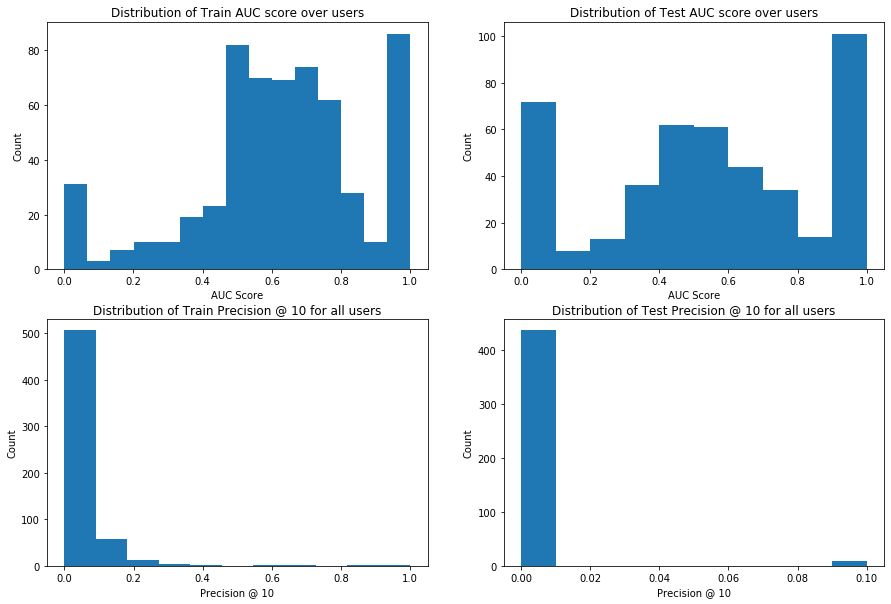



CPU times: user 17 s, sys: 52.3 ms, total: 17.1 s
Wall time: 16.6 s


In [6]:
%%time

sparse_mat = spark_to_sparse(ratings_spark_df)
lightfm_model(sparse_mat, prec_at_k=10, train_split=0.8)

### 2.4. Neighborhood based method using Nearest Neighbor

We use Nearest Neighbor algorithm with z-score normalization of each user

In [7]:
%%time

# Defining parameters for Nearest Neighbor model
sim_options = {'name': 'cosine',
               'user_based': True
               }
model = KNNWithZScore(sim_options=sim_options)

KNN(model=model, df=ratings_spark_df)

Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0642  1.0468  1.0846  1.0811  1.0744  1.0702  0.0136  
MAE (testset)     0.8221  0.8006  0.8163  0.8277  0.8134  0.8160  0.0092  
Fit time          0.06    0.05    0.04    0.05    0.04    0.05    0.00    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    


CPU times: user 846 ms, sys: 4.05 ms, total: 850 ms
Wall time: 988 ms


#### We observe that the Baseline Bias model performs quite well, and other more sophesiticated models (except lightFM) don't yield significant improvments over it hence the Bias model might be the most suited for production

#### We observe that LightFm model has high AUC, meaning it is producing quantifiably quality results.